In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
#import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

from IPython.display import Image

/opt/homebrew/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

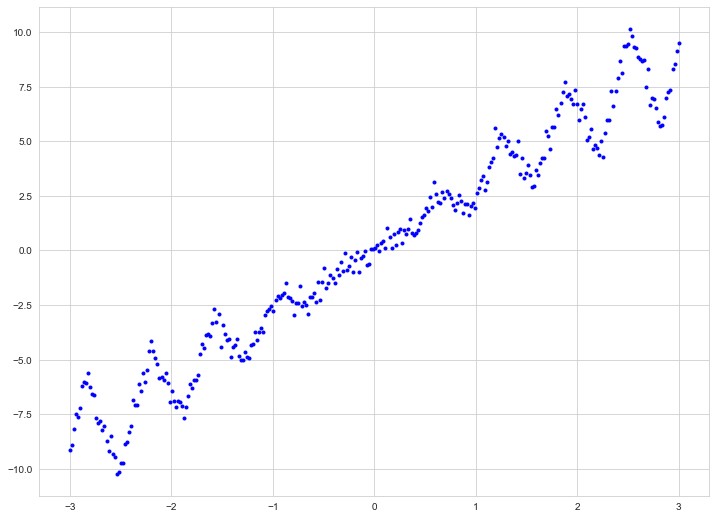

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axs, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    axs.plot(X.reshape(-1), y.reshape(-1), "b.")
    axs.plot(x1, y_pred, linewidth=2, color='green', label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

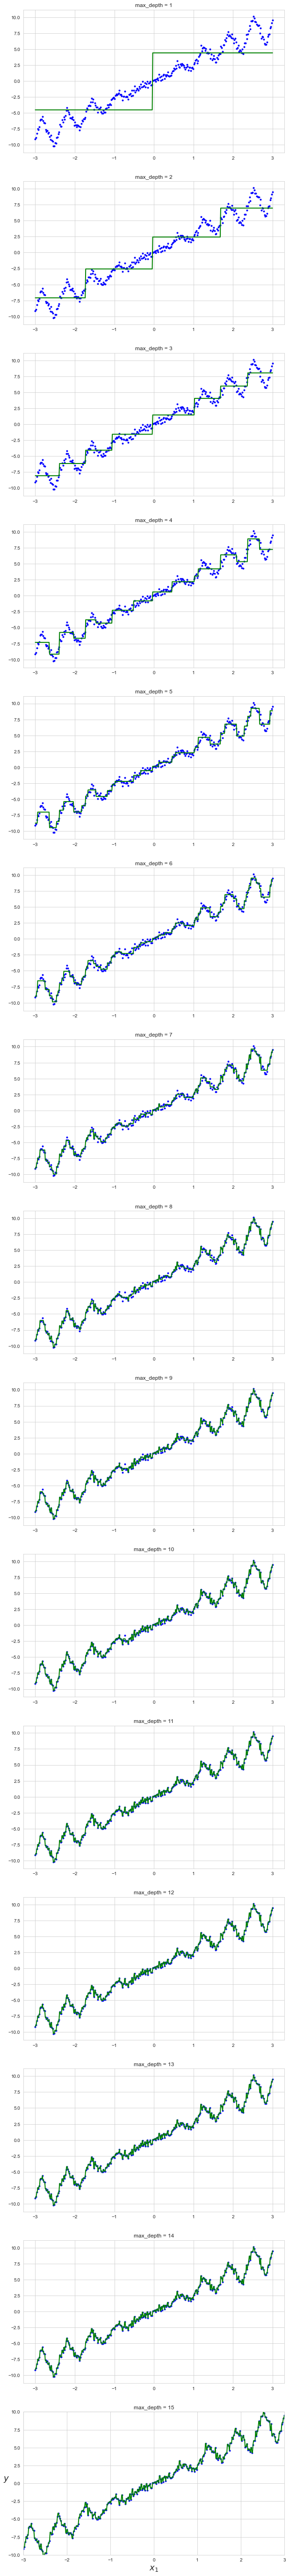

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
fig, axs = plt.subplots(15, figsize=(10,100))
for i in range(1,16):
    tree = DecisionTreeRegressor(max_depth=i)
    tree.fit(X, y)
    axs[i-1].set_title(f'max_depth = {i}')
    plot_regression_predictions(tree, X, y, axs[i-1])

<font color="#f3ca6e">Так, в общем меня уже на 6 все в принципе устраивало, а к 10ти оно уже изучило все точечки бедное</font>

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

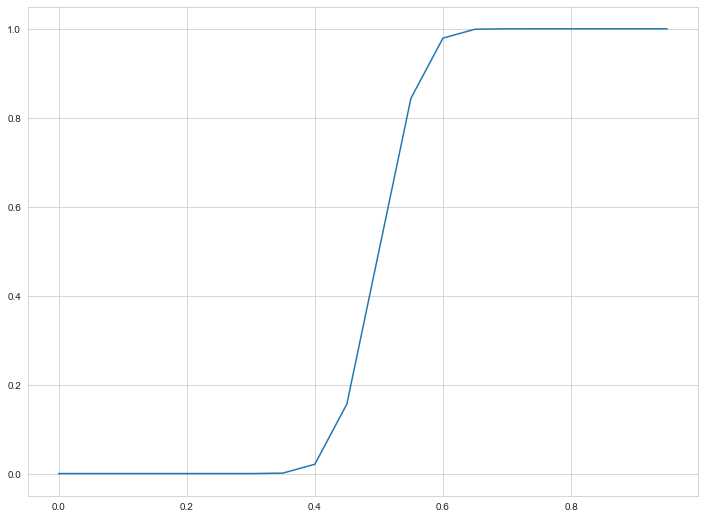

In [7]:
mu= []
pi = np.arange(0, 1, 0.05)
for p in pi:
    #pep8 прасти
    mu.append(np.sum(np.array([math.comb(101, i) * p**i * (1-p)**(101-i) for i in range(51,102)])))
plt.plot(pi, mu)

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

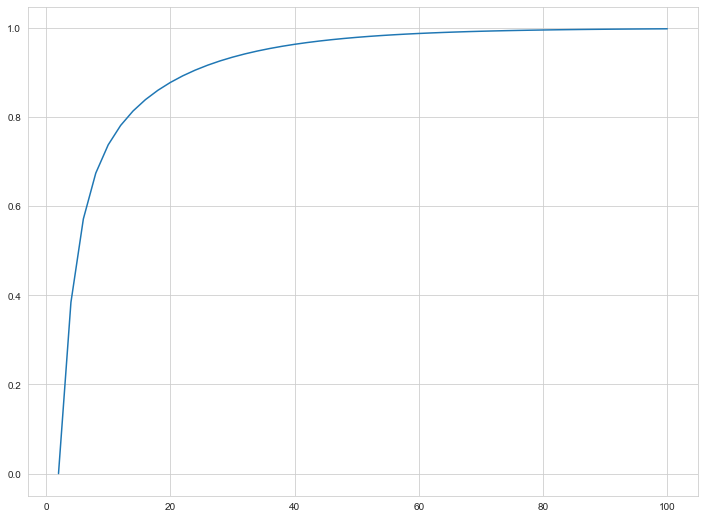

In [9]:
mu= []
N = np.arange(2, 101, 2)
for n in N:
    i = math.floor(n/2) + 1
    #pep8 прасти [2]
    mu.append(np.sum(np.array([math.comb(n, j) * 0.65**j * 0.35**(n-j) for j in range(i,n)])))
plt.plot(N, mu)

<font color="#f3ca6e">Опишите ваши наблюдения:</font>
* с увеличением p увеличивается и вероятностm правильно классифицировать объект
* с увеличением кол-ва моделей увеличивается и вероятностm правильно классифицировать объект

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [10]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(0, self.n_estimators-1):
            np.random.seed(self.random_state + i)
            feat_ids = np.random.choice(np.arange(X.shape[1]), 
                                        size=self.max_features, 
                                        replace=False)
            self.feat_ids_by_tree.append(feat_ids)
            pseudosample_idx = np.random.choice(np.arange(X.shape[0]), size=X.shape[0], replace=True)
            pseudosample = X[pseudosample_idx][:, feat_ids]
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth, 
                max_features=self.max_features, 
                random_state=self.random_state+i)
            tree.fit(pseudosample, y[pseudosample_idx])
            self.trees.append(tree)
        
        return self
        
    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        pred_y = []
        for tree, features in zip(self.trees, self.feat_ids_by_tree):
            pred_y.append(tree.predict_proba(X[:,features]))
        return np.average(pred_y, axis=0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [11]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

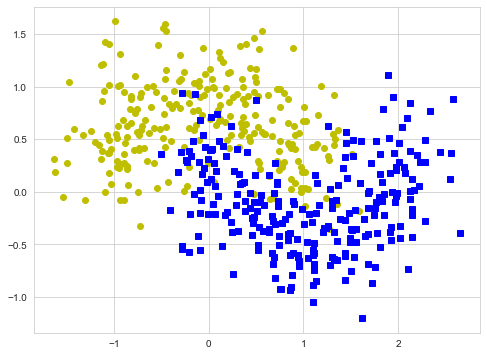

In [12]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

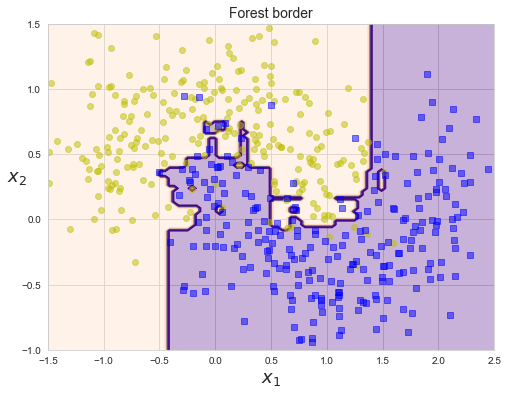

In [13]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

plt.figure(figsize=(8, 6))
rf = RandomForestClassifierCustom(max_depth=10, max_features=2, random_state=SEED)
rf.fit(X_train, y_train)
plot_decision_boundary(rf, X, y)
plt.title("Forest border", fontsize=14)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

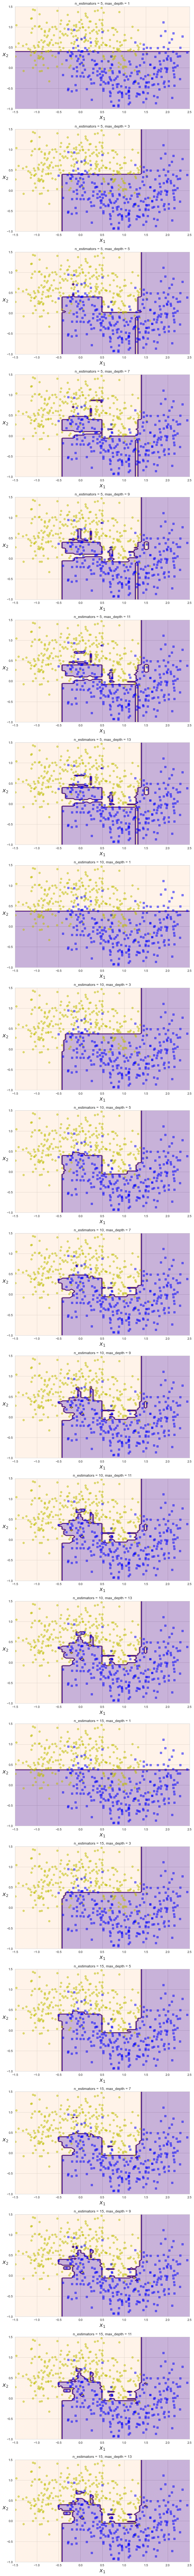

In [14]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
def plot_decision_boundary_with_axs(clf, X, y, axs, 
                                    axes=[-1.5, 2.5, -1, 1.5], 
                                    alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    axs.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        axs.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    axs.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    axs.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    axs.axis(axes)
    axs.set_xlabel(r"$x_1$", fontsize=18)
    axs.set_ylabel(r"$x_2$", fontsize=18, rotation=0)


fig, axs = plt.subplots(21, figsize=(10,150))
i = 0
for estimator in range(5, 20, 5):
    for depth in range(1, 15, 2):
        rf = RandomForestClassifierCustom(n_estimators=estimator, max_depth=depth, 
                                          max_features=2, random_state=SEED)
        rf.fit(X_train, y_train)
        plot_decision_boundary_with_axs(rf, X, y, axs[i])
        axs[i].set_title(f'n_estimators = {estimator}, max_depth = {depth}')
        i += 1

<font color="#f3ca6e">Ох, с n_estimators = 5 и max_depth = 5 меня уже устраивает</font>

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [15]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [16]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [18]:
# посмотрим скока фич вообще
X.shape[1]

30

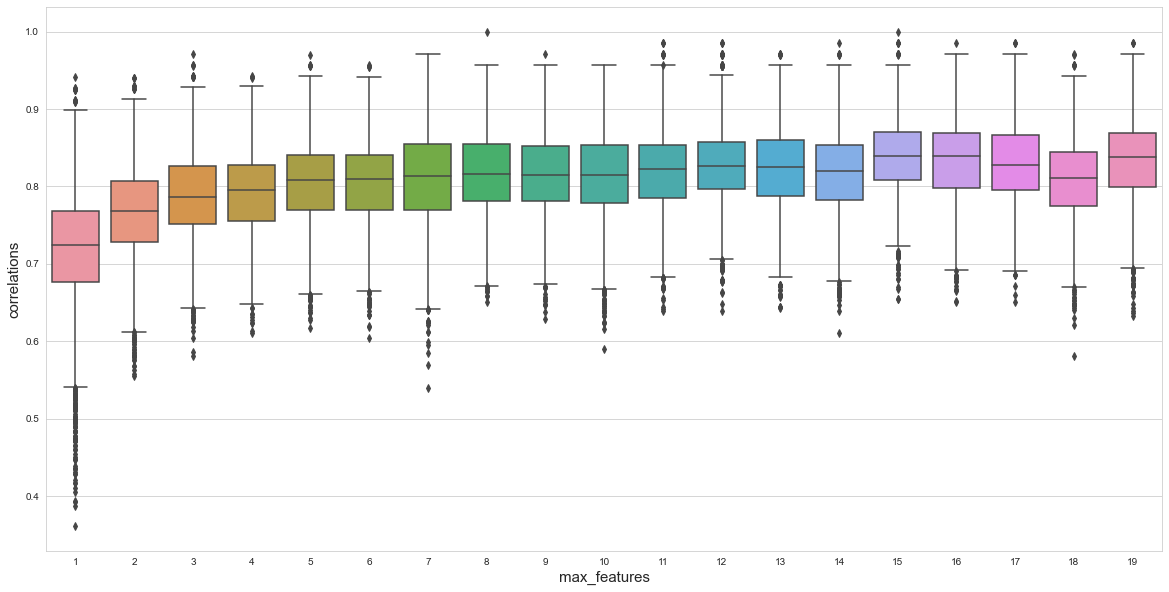

In [19]:
corr_arr = []
for n_features in range(1,20):
    rf = RandomForestClassifier(max_features=n_features, n_jobs=-1)
    rf.fit(X_train, y_train)
    corr_arr.append(base_model_pair_correlation(rf, X_test))


plt.figure(figsize=(20, 10))
sns.boxplot(data=pd.DataFrame(np.array(corr_arr).T, columns=range(1,20)))
plt.xlabel('max_features', fontsize=15)
plt.ylabel('correlations', fontsize=15)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [20]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

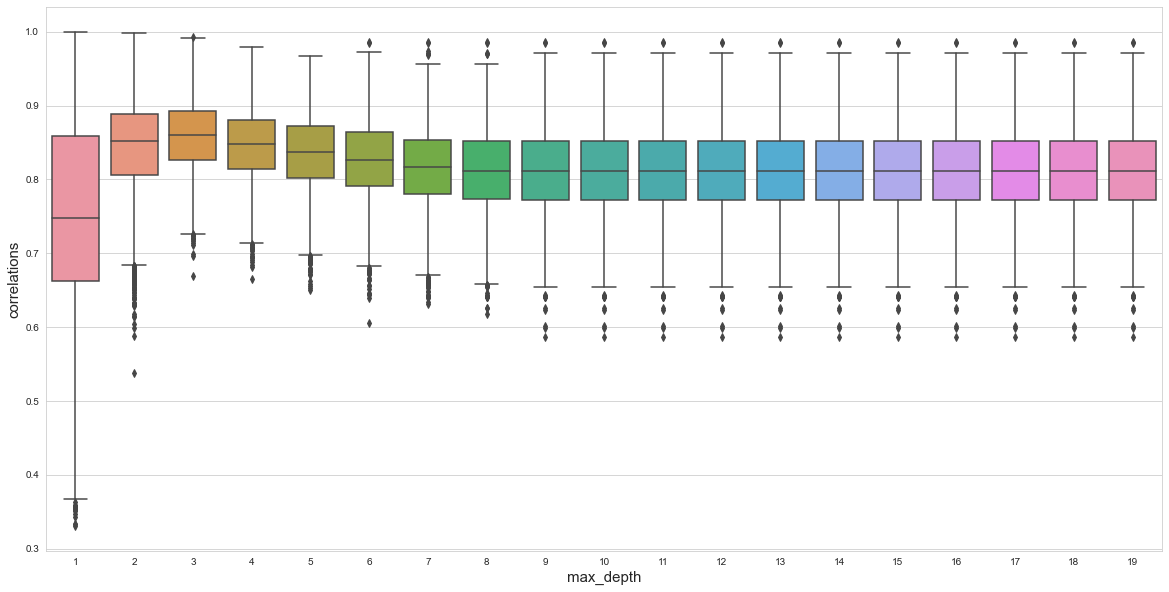

In [21]:
corr_arr = []
for depth in range(1,20):
    rf = RandomForestClassifier(max_depth=depth, random_state=SEED)
    rf.fit(X_train, y_train)
    corr_arr.append(base_model_pair_correlation(rf, X_test))


plt.figure(figsize=(20, 10))
sns.boxplot(data=pd.DataFrame(np.array(corr_arr).T, columns=range(1,20)))
plt.xlabel('max_depth', fontsize=15)
plt.ylabel('correlations', fontsize=15)
plt.show()

<font color="#f3ca6e">Опишите ваши наблюдения:</font>

* чем больше max_features, тем больше корреляция предсказаний деревьев
* чем больше max_depth, тем меньше корреляция предсказаний деревьев

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/ronitf/heart-disease-uci).

In [22]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

/opt/homebrew/lib/python3.10/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [23]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [24]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
# cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED) кэт прасти
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("LGBM", lgbm), ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [25]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')


## END YOUR CODE HERE ##

for model in [dt, rf, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
[20:20:37] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:37] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [26]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [27]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [28]:
voting_hard.fit(X_train, y_train)
base_model_pair_correlation_for_voting_clf(voting_hard, X_test)

[20:20:41] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:41] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  RandomForestClassifier(n_estimators=50, random_state=111),
  0.8134894007824369),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  ExtraTreesClassifier(random_state=111),
  0.7749544834941167),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  KNeighborsClassifier(weights='distance'),
  0.3133294966283547),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(kernel='linear', probability=True, random_state=111),
  0.7153743909950714),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(probability=True, random_state=111),
  0.28201353566953796),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  LGBMClassifier(random_state=111),
  0.8282760696670939),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  LGBMClassifier(baggi

<font color="#f3ca6e">В общем, корреляции я посмотрела, но делать буду перебором все равно</font>

In [29]:
max_score = 0
for i in range(1,6):
    for combination in combinations(base_models, i):
        voting_soft_2 = VotingClassifier(estimators=combination, voting='soft', n_jobs=-1)
        voting_soft_2.fit(X_train, y_train)
        score = f1_score(y_test,voting_soft_2.predict(X_test))
        if score > max_score: 
            max_score = score
            company = combination
print(max_score)
print(company)

/opt/homebrew/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/o

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64I

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:20:48] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:49] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:51] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:20:43] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:45] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:47] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[20:20:46] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:47] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:20:44] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[20:20:53] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[20:21:04] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:07] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:20:50] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:53] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:58] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:20:45] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:02] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:06] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[20:20:55] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:56] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:22:51] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:54] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:55] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:23:06] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:12] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:12] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:23:08] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:10] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:10] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:23:31] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:35] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:48] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:23:47] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:48] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:53] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:23:29] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:32] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:33] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:24:04] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:05] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:10] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:24:00] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:04] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:06] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:25:31] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:32] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:36] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:25:51] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:52] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:04] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:25:12] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:12] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:12] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:26:11] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:12] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:13] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:26:05] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:06] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:10] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[20:25:39] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:54] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:56] WARNING: /private/var/folders/fk/6kc2hm854bnfb2k84_ffgpg00000gn/T/pip-install-_hscgjpq/xgboost_9720fb9c475a4946903dfb4d21b9d51f/build/temp.macosx-12-arm64-3.10/xgboost/src/l

/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

0.9166666666666666
(('ETC', ExtraTreesClassifier(random_state=111)), ('LR', LogisticRegression(max_iter=10000, solver='liblinear')), ('NB', GaussianNB()))


<font color="#f3ca6e">Шах и мат</font>

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [30]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

<font color="#f3ca6e">Посмотрела я описание данных на каггле и решила, что State и Phone уберем, а с Int'l Plan и VMail Plan сделаем лейбл энкодинг... Не знаю, что за чудовище ставило точки в таргете, ну да ладно</font>

In [32]:
data.drop(['State', 'Phone'], inplace=True, axis=1)

In [33]:
le = LabelEncoder()
data["Int'l Plan"] = le.fit_transform(data["Int'l Plan"])
data["VMail Plan"] = le.fit_transform(data["VMail Plan"])
data['Churn?'] = le.fit_transform(data['Churn?'])

<font color="#f3ca6e">А теперь разделим на Х и у, потом на тест и трейн и тд </font>

In [34]:
y = data.pop('Churn?')
X = data.copy()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED)

<font color="#f3ca6e">Посмотрим на результат без параметров</font>

In [36]:
my_forest = xgboost.XGBRFClassifier(n_jobs=-1, random_state=SEED)
my_forest.fit(X_train, y_train, 
              eval_metric='auc', 
              eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.92018


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False, gamma=0,
                gpu_id=-1, importance_type=None, interaction_constraints='',
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=-1,
                num_parallel_tree=100, objective='binary:logistic',
                predictor='auto', random_state=111, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None)

<font color="#f3ca6e">Ну все, в принципе в мл можно дальше не разбираться судя по всему, расходимся</font>

<font color="#f3ca6e">Ладно, попробуем еще что-нибудь</font>

In [37]:
my_forest_2 = xgboost.XGBRFClassifier(n_estimators=500, learning_rate=0.02, max_depth=10, n_jobs=-1, random_state=SEED)
my_forest_2.fit(X_train, y_train, 
              eval_metric='auc', 
              eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.92371


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False, gamma=0,
                gpu_id=-1, importance_type=None, interaction_constraints='',
                learning_rate=0.02, max_delta_step=0, max_depth=10,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=500, n_jobs=-1, num_parallel_tree=500,
                objective='binary:logistic', predictor='auto', random_state=111,
                reg_alpha=0, scale_pos_weight=1, tree_method='exact',
                validate_parameters=1, verbosity=None)

In [38]:
my_lgbm = lightgbm.LGBMClassifier(n_estimators=300, 
                                  learning_rate=0.01,
                                  num_leaves=170,
                                  min_gain_to_split=0.01,
                                  random_state=SEED, 
                                  njobs=-1)
my_lgbm.fit(X_train, y_train, 
              eval_metric='auc', 
              eval_set=[(X_test, y_test)])

[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[1]	valid_0's auc: 0.881087	valid_0's binary_logloss: 0.408281
[2]	valid_0's auc: 0.883422	valid_0's binary_logloss: 0.402548
[3]	valid_0's auc: 0.891652	valid_0's binary_logloss: 0.397254
[4]	valid_0's auc: 0.891513	valid_0's binary_logloss: 0.39208
[5]	valid_0's auc: 0.892713	valid_0's binary_logloss: 0.387301
[6]	valid_0's auc: 0.892968	valid_0's binary_logloss: 0.382677
[7]	valid_0's auc: 0.89255	valid_0's binary_logloss: 0.378308
[8]	valid_0's auc: 0.893199	valid_0's binary_logloss: 0.374057
[9]	valid_0's auc: 0.892574	valid_0's binary_logloss: 0.369981
[10]	valid_0's auc: 0.885891	valid_0's binary_logloss: 0.365984
[11]	valid_0's auc: 0.885752	valid_0's binary_logloss: 0.362137
[12]	valid_0's auc: 0.885845	valid_0's binary_logloss: 0.358545
[13]	valid_0's auc: 0.887195	valid_0's binary_logloss: 0.354906
[14]	va

[129]	valid_0's auc: 0.923788	valid_0's binary_logloss: 0.190667
[130]	valid_0's auc: 0.923962	valid_0's binary_logloss: 0.190076
[131]	valid_0's auc: 0.924078	valid_0's binary_logloss: 0.189464
[132]	valid_0's auc: 0.923997	valid_0's binary_logloss: 0.188946
[133]	valid_0's auc: 0.924043	valid_0's binary_logloss: 0.188324
[134]	valid_0's auc: 0.924032	valid_0's binary_logloss: 0.187771
[135]	valid_0's auc: 0.924043	valid_0's binary_logloss: 0.187306
[136]	valid_0's auc: 0.924101	valid_0's binary_logloss: 0.186723
[137]	valid_0's auc: 0.924078	valid_0's binary_logloss: 0.186191
[138]	valid_0's auc: 0.924183	valid_0's binary_logloss: 0.185755
[139]	valid_0's auc: 0.924159	valid_0's binary_logloss: 0.185196
[140]	valid_0's auc: 0.924194	valid_0's binary_logloss: 0.184723
[141]	valid_0's auc: 0.924356	valid_0's binary_logloss: 0.184255
[142]	valid_0's auc: 0.924426	valid_0's binary_logloss: 0.183741
[143]	valid_0's auc: 0.924264	valid_0's binary_logloss: 0.183238
[144]	valid_0's auc: 0.92

[267]	valid_0's auc: 0.927799	valid_0's binary_logloss: 0.153018
[268]	valid_0's auc: 0.927776	valid_0's binary_logloss: 0.15292
[269]	valid_0's auc: 0.927764	valid_0's binary_logloss: 0.152855
[270]	valid_0's auc: 0.92788	valid_0's binary_logloss: 0.152722
[271]	valid_0's auc: 0.927695	valid_0's binary_logloss: 0.152651
[272]	valid_0's auc: 0.927393	valid_0's binary_logloss: 0.152627
[273]	valid_0's auc: 0.927463	valid_0's binary_logloss: 0.152485
[274]	valid_0's auc: 0.927335	valid_0's binary_logloss: 0.152403
[275]	valid_0's auc: 0.927208	valid_0's binary_logloss: 0.152375
[276]	valid_0's auc: 0.927335	valid_0's binary_logloss: 0.152247
[277]	valid_0's auc: 0.927335	valid_0's binary_logloss: 0.152162
[278]	valid_0's auc: 0.927277	valid_0's binary_logloss: 0.152139
[279]	valid_0's auc: 0.927115	valid_0's binary_logloss: 0.152116
[280]	valid_0's auc: 0.927057	valid_0's binary_logloss: 0.151983
[281]	valid_0's auc: 0.926883	valid_0's binary_logloss: 0.151932
[282]	valid_0's auc: 0.9270

LGBMClassifier(learning_rate=0.01, min_gain_to_split=0.01, n_estimators=300,
               njobs=-1, num_leaves=170, random_state=111)

<font color="#f3ca6e">В общем я руками перебрала еще многа параметров, но скор твыше особо не был, аидимо my_forest_2 лучшее, что я могу предложить миру... Зато нарисовала картинку</font>

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [39]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

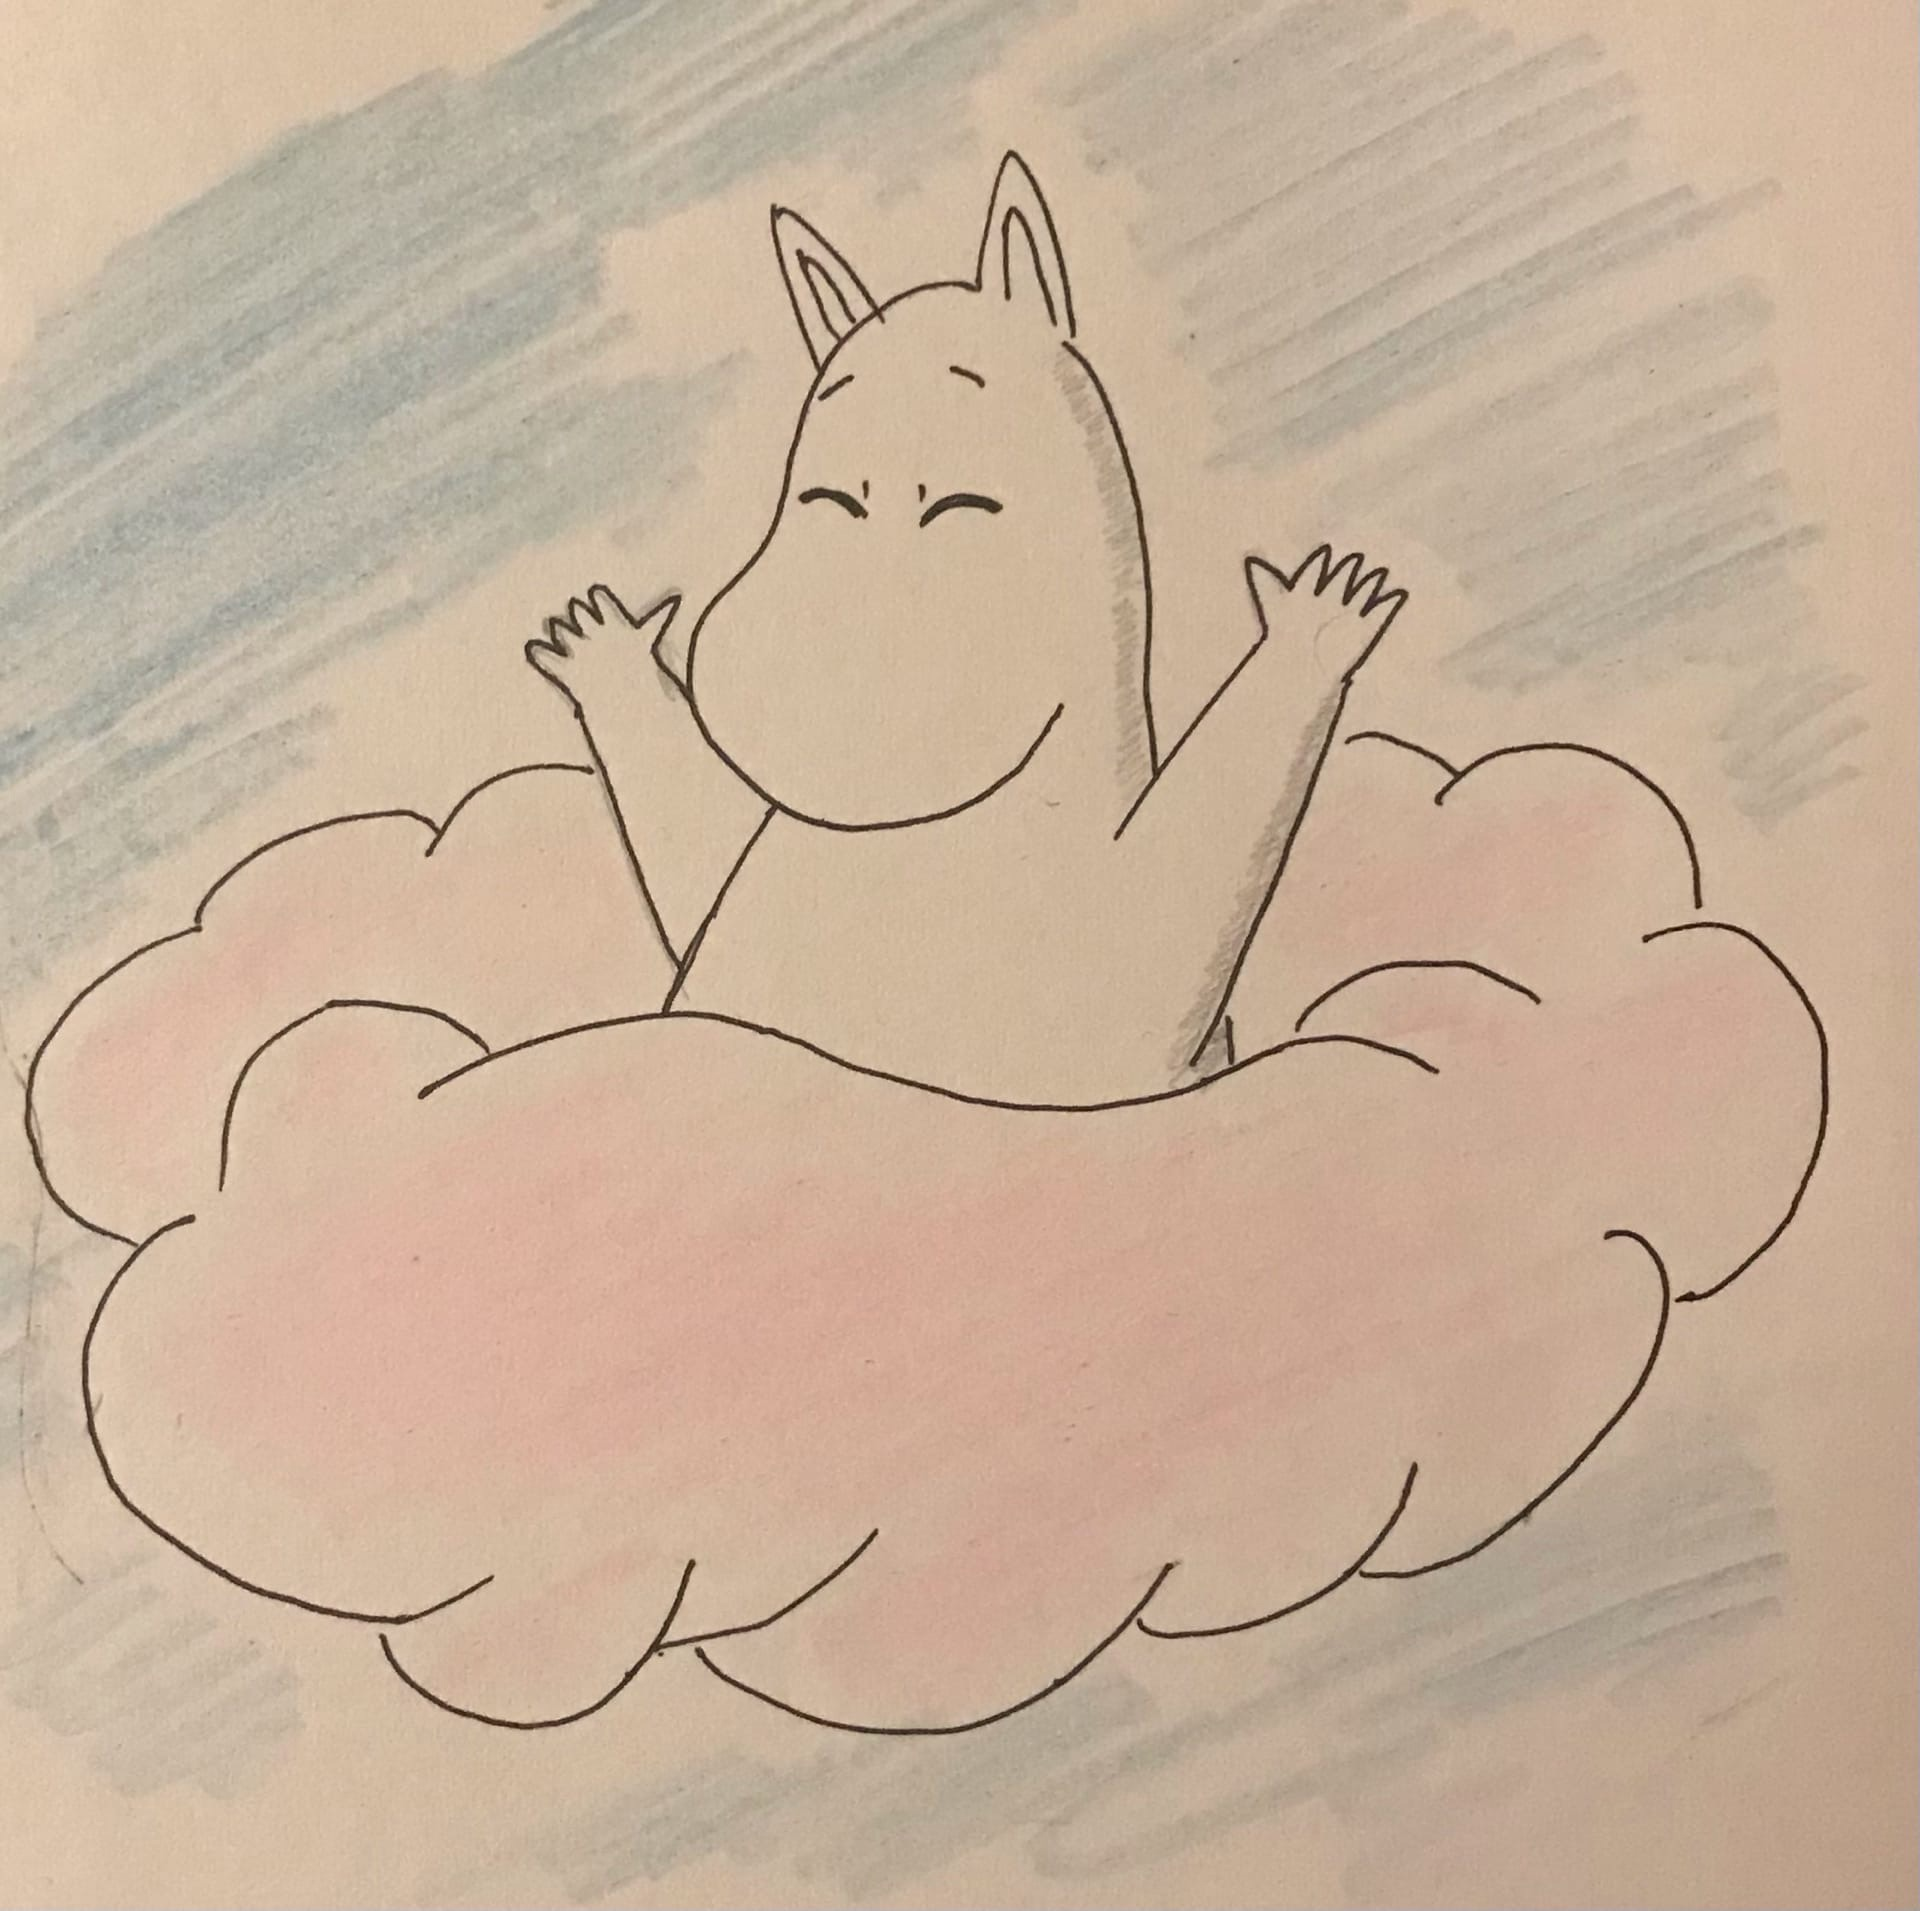

In [40]:
Image("./pic.jpeg", width=400)

<font color="#f3ca6e">Это я пока делаю мл радуюсь и витаю в облаках, не обращая внимание на то, куда все катится</font>

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

<font color="#f3ca6e">me fine</font>